In [161]:
!pip install yellowbrick

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Import data

In [3]:
audio_features = pd.read_csv('audio_features.csv')
audio_features = audio_features.iloc[:,1:]
audio_features = audio_features.drop(['type', 'id', 'uri', 'track_href', 'analysis_url'], axis=1)

charts_pop = pd.read_csv('charts_pop.csv')

sentiment = pd.read_csv('sentiment.csv')

In [4]:
data = audio_features
data['popularity'] = charts_pop.popularity
data['year'] = charts_pop.year
data['sentiment_score'] = sentiment.sentiment_score
data['sentiment'] = sentiment.sentiment

In [5]:
data.head()

,song,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,year,sentiment_score,sentiment
0,Rolling In The Deep,Adele,0.730,0.769,8.0,-5.114,1.0,0.0298,0.13800,0.000000,0.0473,0.507,104.948,228093.0,4.0,79.0,2011.0,0.9850,pos
1,Party Rock Anthem,LMFAO Featuring Lauren Bennett & GoonRock,0.744,0.733,5.0,-4.061,0.0,0.1410,0.01900,0.000000,0.2600,0.340,130.012,264147.0,4.0,0.0,2011.0,0.9227,pos
2,Firework,Katy Perry,0.637,0.867,8.0,-3.686,1.0,0.0500,0.14300,0.000000,0.1100,0.652,124.069,227973.0,4.0,0.0,2011.0,0.8079,pos
3,E.T.,Katy Perry Featuring Kanye West,0.534,0.633,5.0,-4.921,0.0,0.0406,0.05000,0.000027,0.1130,0.163,136.038,200893.0,4.0,47.0,2011.0,-0.5204,neg
4,Give Me Everything,"Pitbull Featuring Ne-Yo, Afrojack & Nayer",0.709,0.669,0.0,-4.093,0.0,0.0403,0.00647,0.000554,0.0399,0.666,128.989,366320.0,4.0,23.0,2011.0,0.9760,pos


### Quality Check

In [75]:
data.isna().sum()

song                 0
artist               0
danceability        28
energy              28
key                 28
loudness            28
mode                28
speechiness         28
acousticness        28
instrumentalness    28
liveness            28
valence             28
tempo               28
duration_ms         28
time_signature      28
popularity          27
year                 0
sentiment_score     76
sentiment           76
dtype: int64

In [84]:
#filling with means, and mean of sentiment score is 0.31, so sentiment column will be filled with corresponding sentiment (positive)
data = data.fillna(data.mean())
data['sentiment'] = data['sentiment'].fillna('pos')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [85]:
data.duplicated().sum()

0

### EDA

In [6]:
by_year = data.groupby('year').mean()
by_year

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,sentiment_score
year,,,,,,,,,,,,,,,
2011.0,0.624194,0.732434,5.551020,-5.550531,0.632653,0.104017,0.134287,0.023647,0.197543,0.522300,130.328000,236319.602041,4.000000,38.469388,0.460899
2012.0,0.651500,0.718439,5.265306,-5.570214,0.551020,0.086669,0.130520,0.020436,0.199847,0.548541,125.310633,227921.183673,3.959184,42.795918,0.413261
2013.0,0.619969,0.708711,5.474227,-5.949598,0.680412,0.091072,0.150051,0.038360,0.205411,0.540619,120.013608,240529.185567,4.010309,43.824742,0.352429
2014.0,0.626320,0.686856,6.309278,-5.835701,0.628866,0.099053,0.169833,0.004184,0.196733,0.527892,123.000763,239322.092784,3.989691,45.855670,0.335892
2015.0,0.658206,0.649556,5.432990,-6.242423,0.618557,0.104316,0.189333,0.002344,0.198802,0.502002,122.892454,221168.134021,3.969072,46.474227,0.428586
2016.0,0.650802,0.651351,5.500000,-6.303104,0.500000,0.113022,0.167652,0.016797,0.190046,0.451704,119.841313,225089.083333,3.968750,48.000000,0.216404
2017.0,0.688215,0.652817,5.204301,-6.196237,0.483871,0.124586,0.166085,0.014869,0.170587,0.474826,119.209398,217311.139785,4.000000,42.150538,0.229781
2018.0,0.703179,0.641663,6.052632,-6.328053,0.631579,0.108791,0.203003,0.034857,0.176333,0.443161,119.551505,209919.168421,3.968421,48.084211,0.256239
2019.0,0.687798,0.616333,4.666667,-6.365828,0.545455,0.124981,0.220112,0.033305,0.183627,0.473960,123.875737,200058.747475,4.010101,40.530000,0.256776


Text(0, 0.5, 'Sentiment')

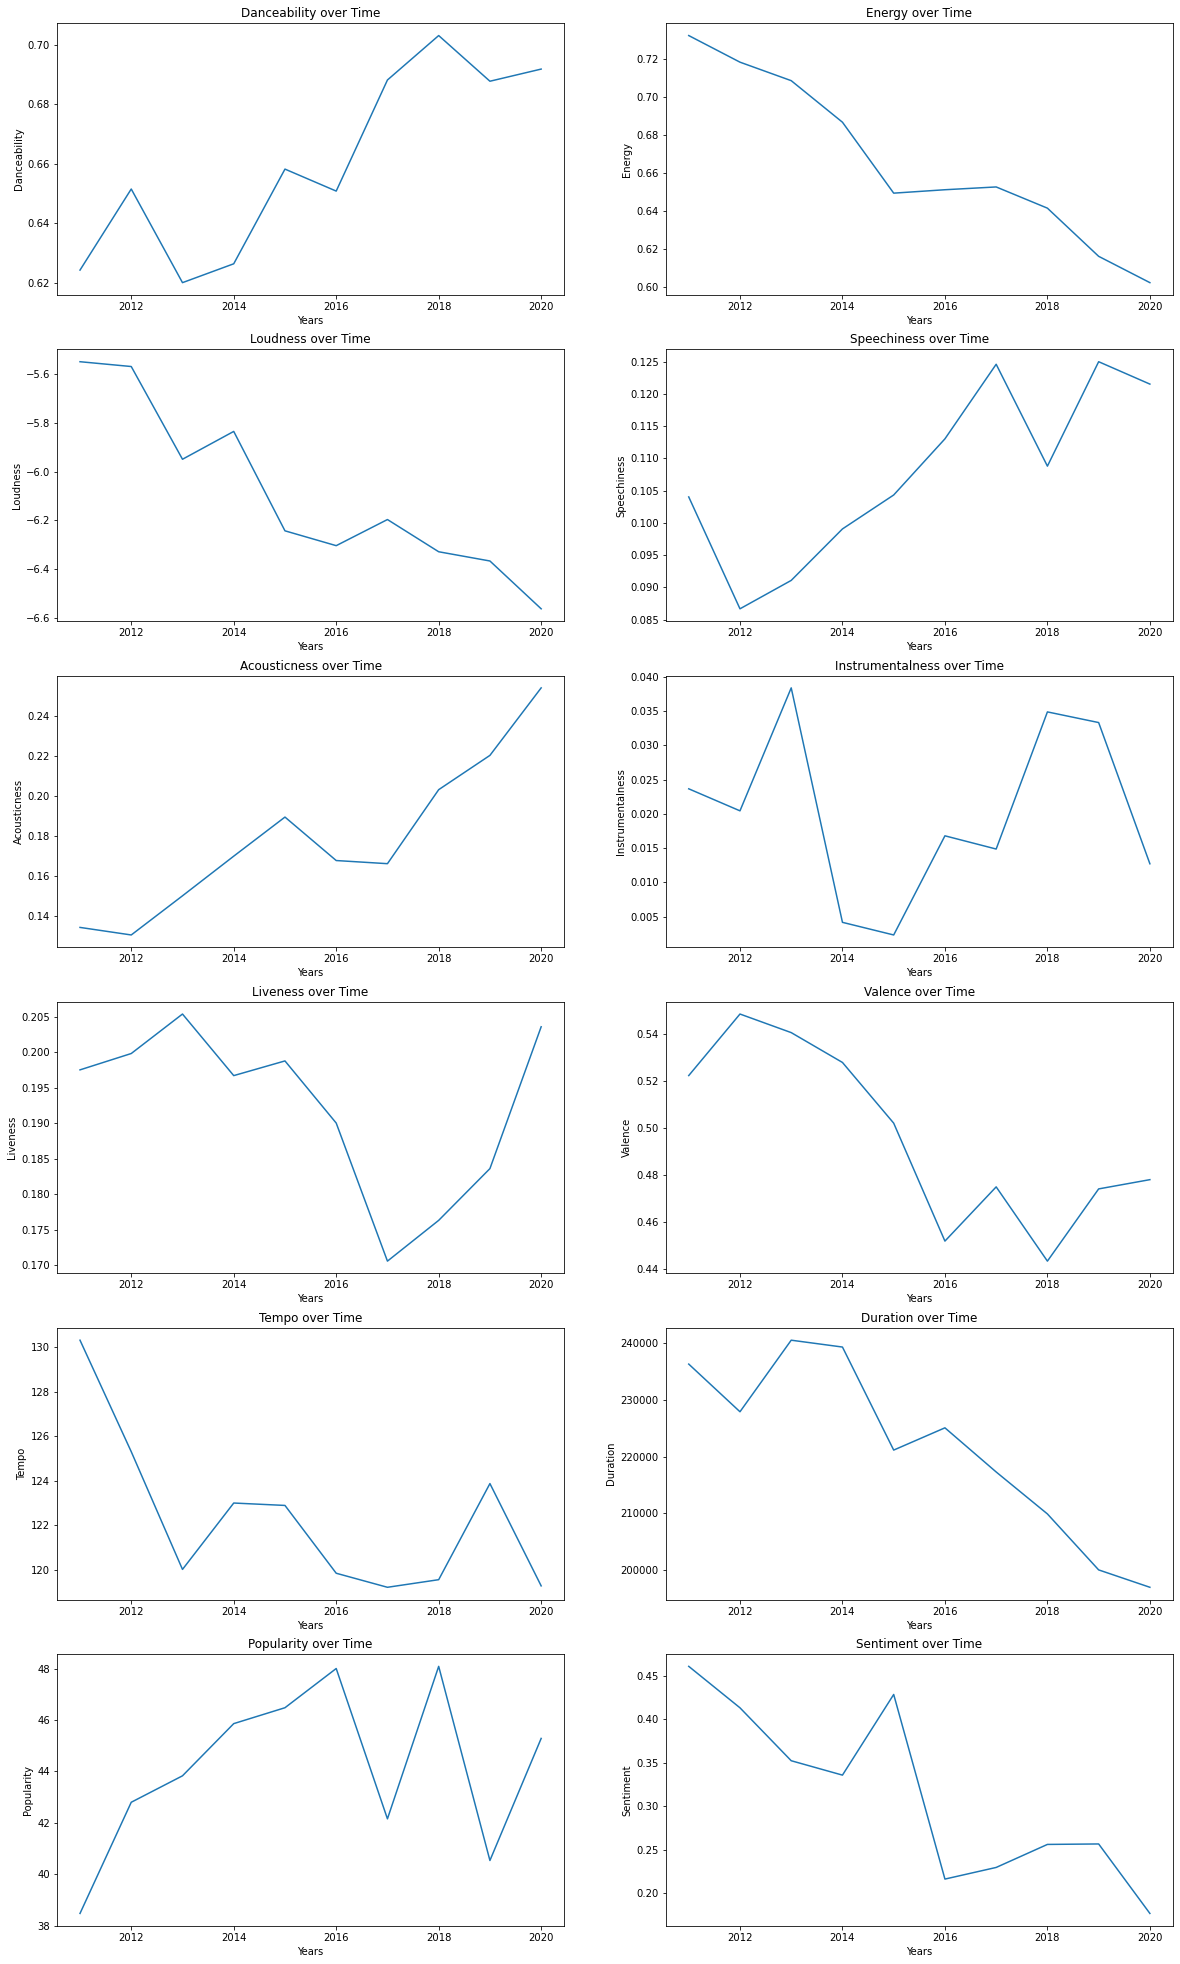

In [7]:
fig, axs = plt.subplots(6, 2, figsize=(20, 35))

axs[0][0].plot(by_year.index, by_year.danceability)
axs[0][0].set_title('Danceability over Time')
axs[0][0].set_xlabel('Years')
axs[0][0].set_ylabel('Danceability')

axs[0][1].plot(by_year.index, by_year.energy)
axs[0][1].set_title('Energy over Time')
axs[0][1].set_xlabel('Years')
axs[0][1].set_ylabel('Energy')

axs[1][0].plot(by_year.index, by_year.loudness)
axs[1][0].set_title('Loudness over Time')
axs[1][0].set_xlabel('Years')
axs[1][0].set_ylabel('Loudness')

axs[1][1].plot(by_year.index, by_year.speechiness)
axs[1][1].set_title('Speechiness over Time')
axs[1][1].set_xlabel('Years')
axs[1][1].set_ylabel('Speechiness')

axs[2][0].plot(by_year.index, by_year.acousticness)
axs[2][0].set_title('Acousticness over Time')
axs[2][0].set_xlabel('Years')
axs[2][0].set_ylabel('Acousticness')

axs[2][1].plot(by_year.index, by_year.instrumentalness)
axs[2][1].set_title('Instrumentalness over Time')
axs[2][1].set_xlabel('Years')
axs[2][1].set_ylabel('Instrumentalness')

axs[3][0].plot(by_year.index, by_year.liveness)
axs[3][0].set_title('Liveness over Time')
axs[3][0].set_xlabel('Years')
axs[3][0].set_ylabel('Liveness')

axs[3][1].plot(by_year.index, by_year.valence)
axs[3][1].set_title('Valence over Time')
axs[3][1].set_xlabel('Years')
axs[3][1].set_ylabel('Valence')

axs[4][0].plot(by_year.index, by_year.tempo)
axs[4][0].set_title('Tempo over Time')
axs[4][0].set_xlabel('Years')
axs[4][0].set_ylabel('Tempo')

axs[4][1].plot(by_year.index, by_year.duration_ms)
axs[4][1].set_title('Duration over Time')
axs[4][1].set_xlabel('Years')
axs[4][1].set_ylabel('Duration')

axs[5][0].plot(by_year.index, by_year.popularity)
axs[5][0].set_title('Popularity over Time')
axs[5][0].set_xlabel('Years')
axs[5][0].set_ylabel('Popularity')

axs[5][1].plot(by_year.index, by_year.sentiment_score)
axs[5][1].set_title('Sentiment over Time')
axs[5][1].set_xlabel('Years')
axs[5][1].set_ylabel('Sentiment')


In [15]:
def get_diff(col):
    diff = (by_year[col][2020]-by_year[col][2011])/by_year[col][2011]
    
    return diff

In [48]:
print("Time period: 2011-2020")

dance_diff = get_diff("danceability")
print(f'There is an upward trend of danceability over time, with a total change of {100*round(dance_diff,3)}%')

energy_diff = get_diff("energy")
print(f'There is a downward trend of energy over time, with a total change of {100*round(energy_diff,3)}%')

loud_diff = get_diff("loudness")
print(f'There is a downward trend of loudness over time, with a total change of {-100*round(loud_diff,3)}%')

speech_diff = get_diff("speechiness")
print(f'There is an upward trend of speechiness over time, with a total change of {100*round(speech_diff,3)}%')

acoustic_diff = get_diff("acousticness")
print(f'There is an upward trend of acousticness over time, with a total change of {100*round(acoustic_diff,3)}%')

inst_diff = get_diff("instrumentalness")
print(f'Instrumentalness across the top 100 sonds was volatile over this time period, with a total change of {100*round(inst_diff,3)}%')

live_diff = get_diff("liveness")
print(f'There was a downward trend of liveness over time, with a strong resurgence after 2017 with a total change of {100*round(live_diff,3)}%')

val_diff = get_diff("valence")
print(f'There is a downward trend of valence over time, with a total change of {100*round(val_diff,3)}%')

tempo_diff = get_diff("tempo")
print(f'There is a downward trend of tempo over time, with a total change of {100*round(energy_diff,3)}%')

dur_diff = get_diff("duration_ms")
print(f'There is a downward trend of song duration over time, with a total change of {100*round(dur_diff,3)}%')

pop_diff = get_diff("popularity")
print(f'There was an upward trend of popularity over time until 2017, where average popularity begins to fluctuate. Over this time period, there was a total change of {100*round(pop_diff,3)}%')

sent_diff = get_diff("sentiment_score")
print(f'There is a downward trend of sentiment over time, with a total change of {100*round(sent_diff,3)}%')


Time period: 2011-2020
There is an upward trend of danceability over time, with a total change of 10.8%
There is a downward trend of energy over time, with a total change of -17.7%
There is a downward trend of loudness over time, with a total change of -18.2%
There is an upward trend of speechiness over time, with a total change of 16.8%
There is an upward trend of acousticness over time, with a total change of 89.0%
Instrumentalness across the top 100 sonds was volatile over this time period, with a total change of -46.2%
There was a downward trend of liveness over time, with a strong resurgence after 2017 with a total change of 3.1%
There is a downward trend of valence over time, with a total change of -8.5%
There is a downward trend of tempo over time, with a total change of -17.7%
There is a downward trend of song duration over time, with a total change of -16.6%
There was an upward trend of popularity over time until 2017, where average popularity begins to fluctuate. Over this ti

**Danceability**: Danceability is a metric Spotify created to describe a song's suitability for dancing based upon tempo, rhythm stability, beat strength, and overall regularity. These metrics relate to the predicatbility of the song. Values range from 0.0 (least suitable) to 1.0 (most suitable). There has been a steady increase of danceability over time, which indicates that Billboard Top 100 songs have become more stable and predictable. 
<br><br>
**Energy**: Energy is another metrics Spotify created to capture the intensity and activity of a song. Values range from 0.0 (least) to 1.0 (most) and takes dynamic range, perceived loudness, timbre, onset rate, and general entropy into account. There has been a steady downward trend of energy. 
<br><br>
**Loudness**: Loudness is measured in decibels and is a single value of the loudness over the entire track. Values typically fall between -60 and 0 db. There has also been a downward trend in loudness, which would contribute to the downward energy trend.
**Speechiness**: Speechiness is a measure that detects the presence of spoken words in a track. Values range from 0.0 (least) to 1.0 (most). There has been a steady upward trend of speechiness.
<br><br>
**Acousticness**: Represents a confidence measure from 0.0 (low) to 1.0 (high) whether the track is acoustic. 
<br><br>
**Instrumentalness**: Indicates the lack of vocals in a track. There was a lot of fluctuation over this time period, but values are very small for this metric, so minor changes result in high percentage changes. 
<br><br>
**Liveness**: Indicates the probability of a live audience in the track. All values are relatively low, with averages all below 0.25, where 0.8 represents a strong likelihood that the track is live. 
<br><br>
**Valence**: Describes the musical positiveness conveyed by a track. Values range from 0.0 (sad, angry, depressed) to 1.0 (happy, cheerful, euphoric) 
<br><br>
**Tempo**: Estimated tempo in beats per minute.
<br><br>
**Duration**: Length of a song in milliseconds.
<br><br>

**Popularity**: Indicates popularity, unsure of how it is calculated.
<br><br>

**Sentiment**: A score assigned to the song based on sentiment analysis using VADER lexicon on the lyrics of a song. 

### Feature Correlations

In [97]:
corr_dict = dict()
for col in by_year.columns:
    corr = pearsonr(data[col], data.popularity)[0]
    corr_dict[col] = corr 

In [98]:
corr_dict

{'danceability': -0.03429235268872753,
 'energy': -0.0015934798110174009,
 'key': -0.042805672873885925,
 'loudness': 0.08848506203855984,
 'mode': -0.029218925465734867,
 'speechiness': -0.013166376440970509,
 'acousticness': -0.02239721797827967,
 'instrumentalness': -0.11622252252784507,
 'liveness': -0.02707767691543063,
 'valence': -0.03889738164342768,
 'tempo': -0.07884272353062008,
 'duration_ms': 0.012875092360635273,
 'time_signature': 0.027234385556650878,
 'popularity': 1.0,
 'sentiment_score': -0.03715739125675037}

**Feature correlations to popularity**: None of the features have a very strong relatinoship to popularity, all values between -0.15 and 0.15

### Data visualziation

Text(0.5, 1.0, 'Danceability vs. Energy')

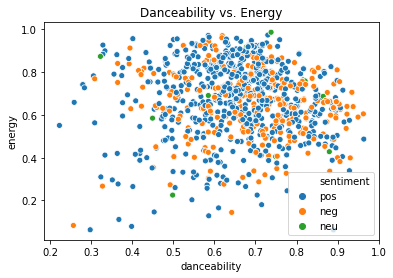

In [99]:
sns.scatterplot(data=data, x="danceability", y="energy", hue='sentiment')
plt.title("Danceability vs. Energy")

Text(0.5, 1.0, 'Valence vs. Popularity')

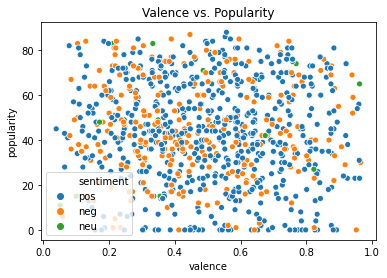

In [101]:
sns.scatterplot(data=data, x="valence", y='popularity', hue="sentiment")
plt.title("Valence vs. Popularity")

Text(0.5, 1.0, 'Energy vs. Popularity')

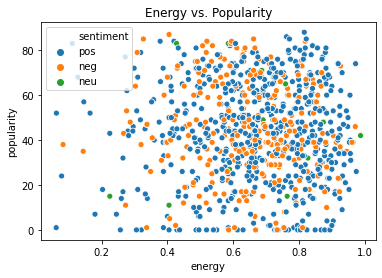

In [102]:
sns.scatterplot(data=data, x="energy", y='popularity', hue="sentiment")
plt.title("Energy vs. Popularity")

Text(0.5, 1.0, 'Danceability vs. Popularity')

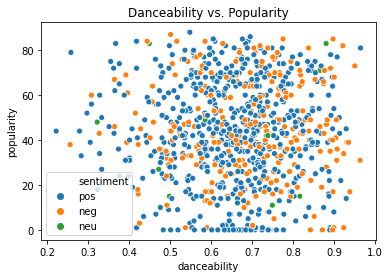

In [103]:
sns.scatterplot(data=data, x="danceability", y='popularity', hue="sentiment")
plt.title("Danceability vs. Popularity")

Text(0.5, 1.0, 'Sentiment Score vs. Popularity')

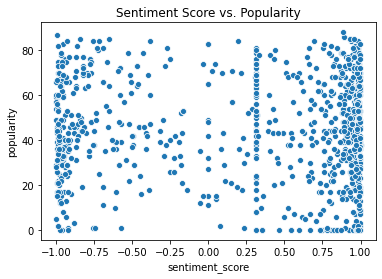

In [104]:
sns.scatterplot(data=data, x="sentiment_score", y='popularity')
plt.title("Sentiment Score vs. Popularity")

In [107]:
# Do positive vs negative diff of means for each feature
by_sent = data.groupby('sentiment').mean()
by_sent

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,year,sentiment_score
sentiment,,,,,,,,,,,,,,,,
neg,0.684681,0.647959,5.457352,-6.108397,0.540123,0.128881,0.168026,0.026599,0.186827,0.463786,121.644967,220271.934400,3.972625,45.376726,2015.945946,-0.782511
neu,0.654467,0.680533,5.866667,-6.222133,0.733333,0.110940,0.164852,0.017696,0.221980,0.479527,120.642067,225080.266667,3.933333,50.266667,2015.400000,0.000533
pos,0.649663,0.673468,5.474426,-6.079335,0.586945,0.098615,0.183604,0.017432,0.194169,0.510984,122.699548,221809.628063,3.983298,43.455513,2015.315866,0.789292


In [115]:
diff_means_dict = dict()
for col in by_year.columns:
    neg = data[data['sentiment']=='neg'][col]
    pos = data[data['sentiment']=='pos'][col]
    t_stat, p_val = ttest_ind(neg, pos)
    
    diff_means_dict[col] = p_val

In [116]:
diff_means_dict

{'danceability': 0.00012358545186690406,
 'energy': 0.030192760684492354,
 'key': 0.9456196501770361,
 'loudness': 0.8678166496339862,
 'mode': 0.1675566025340954,
 'speechiness': 3.9364477949032536e-05,
 'acousticness': 0.33083184273592947,
 'instrumentalness': 0.24267568366635775,
 'liveness': 0.49359426420379027,
 'valence': 0.0013438446840092022,
 'tempo': 0.5914636621419415,
 'duration_ms': 0.6525098851539723,
 'time_signature': 0.5228946418188629,
 'popularity': 0.20833972117565785,
 'sentiment_score': 0.0}

With $\alpha = 0.05$, we can see that positive and negative sentiment songs differ in  loudness, acousticness, instrumentalness, liveness, tempo, duration, and popularity with 95% confidence.

### PCA and Clustering
- PC1 accounts for 17.4% of variance, PC2 accounts for 10.3% of variance. 
- 2D plot only accounts for 27.7% of variance

In [213]:
scaler = StandardScaler()
num = data[by_year.columns]
scaled_data = scaler.fit_transform(num)

In [226]:
pca = PCA(n_components=2)
num = by_year.columns
pca.fit(scaled_data)

PCA(n_components=2)

In [227]:
print("Explained variance: ", pca.explained_variance_ratio_)
print("Singular values: ", pca.singular_values_)

Explained variance:  [0.17468073 0.10329147]
Singular values:  [51.13678225 39.32268206]


In [228]:
pca_X = pca.transform(scaled_data)

Text(0, 0.5, 'PC2')

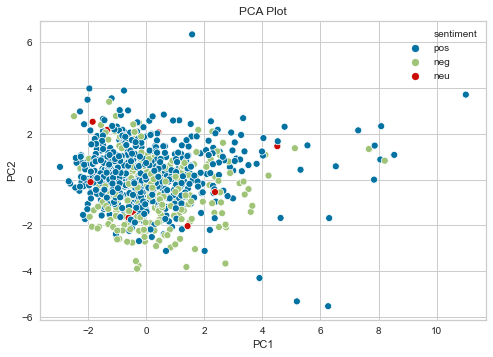

In [231]:
sns.scatterplot(x=pca_X[:,0], y=pca_X[:,1], hue=data.sentiment)
plt.title("PCA Plot")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [217]:
sil_scores = []
distortions = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(pca_X)
    
    silhouette = silhouette_score(pca_X, kmeans.labels_, metric="euclidean")
    sil_scores.append(silhouette)
    
    distortion = sum(np.min(cdist(pca_X, kmeans.cluster_centers_, 
                            "euclidean"), axis=1))/pca_X.shape[0]
    distortions.append(distortion)

Text(0, 0.5, 'Distortion')

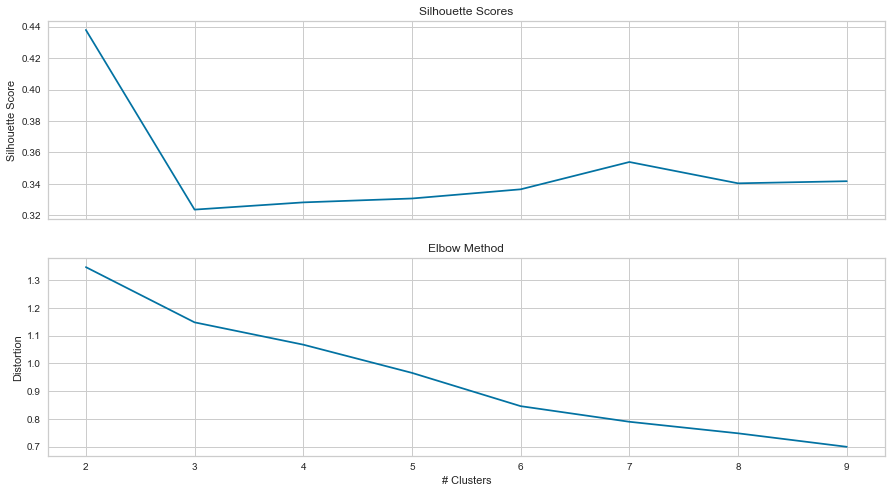

In [218]:
fig, axs = plt.subplots(2, 1, figsize=(15,8), sharex=True)

axs[0].plot(range(2,10),sil_scores)
axs[0].set_title("Silhouette Scores")
axs[0].set_ylabel("Silhouette Score")

axs[1].plot(range(2,10), distortions)
axs[1].set_title("Elbow Method")
axs[1].set_xlabel("# Clusters")
axs[1].set_ylabel("Distortion")

In [234]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(pca_X)

KMeans(n_clusters=7, random_state=0)

Text(0, 0.5, 'PC2')

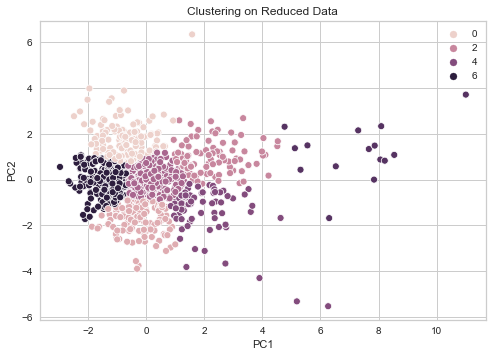

In [235]:
sns.scatterplot(x=pca_X[:,0], y=pca_X[:,1], hue=kmeans.labels_)
plt.title("Clustering on Reduced Data")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [237]:
data['cluster'] = kmeans.labels_

In [238]:
data.groupby('cluster').mean()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,year,sentiment_score
cluster,,,,,,,,,,,,,,,,
0,0.513268,0.761585,4.063380,-5.371979,0.795775,0.061181,0.079921,0.009441,0.287223,0.390273,133.729141,259275.190141,4.021127,42.429577,2014.373239,0.538044
1,0.804089,0.659111,6.525926,-5.849637,0.370370,0.194289,0.107411,0.000813,0.139630,0.594781,119.802526,196547.118519,3.992593,43.600000,2016.859259,-0.119509
2,0.562320,0.443773,4.845361,-8.172959,0.670103,0.060533,0.493234,0.056888,0.152362,0.311394,119.594113,232226.886598,3.835052,41.329897,2015.907216,0.393917
3,0.668476,0.643899,5.508359,-6.127731,0.638070,0.098621,0.160607,0.005743,0.164357,0.446598,118.846125,222491.257470,3.987039,45.356696,2015.855072,0.273621
4,0.756623,0.443909,6.285714,-9.026597,0.545455,0.201469,0.394127,0.018053,0.128790,0.448064,113.415506,189672.012987,3.922078,43.805195,2016.857143,-0.023410
5,0.513733,0.181407,5.800000,-17.744067,0.600000,0.056460,0.859800,0.578928,0.128273,0.376433,124.929800,196396.333333,3.800000,31.933333,2015.333333,0.499973
6,0.673262,0.819871,5.644531,-4.219371,0.464844,0.090601,0.066715,0.005808,0.235962,0.649188,124.762309,219237.062500,4.023438,45.894531,2014.488281,0.511459
